In [43]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import datetime
import seaborn as sns
import gc
import re
# from pandarallel import pandarallel
# pandarallel.initialize()
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
#显示所有列
pd.set_option('display.max_columns', 100)
#显示所有行
pd.set_option('display.max_rows', 100)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',70)

In [50]:
def read():
    train = pd.read_csv('train.csv')
    test1 = pd.read_csv('test1.csv')
    # labels = train['label']
    df1 = train.drop(['Unnamed: 0'], axis=1)
    df2 = test1.drop(['Unnamed: 0'], axis=1)

    df2["label"] = -1
    for col in ["fea_hash"]:
        df1[col] = df1[col].map(lambda x: 0 if len(str(x)) > 16 else int(x))
        df2[col] = df2[col].map(lambda x: 0 if len(str(x)) > 16 else int(x))

    for col in ["android_id", "apptype", "carrier", "ntt", "media_id", "cus_type", "package", 'fea1_hash', "location","fea_hash","dev_height", "dev_ppi", "dev_width"]:
        df1[col] = df1[col].astype("object")
        df2[col] = df2[col].astype("object")

    for col in ["label"]:
        df1[col] = df1[col].astype("int64")
        df2[col] = df2[col].astype("int64")

    df2["label"] = None

    df1["truetime"] = pd.to_datetime(df1['timestamp'], unit='ms', origin=pd.Timestamp('1970-01-01'))
    df2["truetime"] = pd.to_datetime(df2['timestamp'], unit='ms', origin=pd.Timestamp('1970-01-01'))

    df1["day"] = df1.truetime.dt.day
    df2["day"] = df2.truetime.dt.day

    df1["hour"] = df1.truetime.dt.hour
    df2["hour"] = df2.truetime.dt.hour

    df1["minute"] = df1.truetime.dt.minute
    df2["minute"] = df2.truetime.dt.minute

    df1["lan"]=df1["lan"].str.lower()
    df1["lan"]=df1["lan"].apply(lambda x: str(x).replace("-","_"))
    df2["lan"]=df2["lan"].str.lower()
    df2["lan"]=df2["lan"].apply(lambda x: str(x).replace("-","_"))
    
    df1.set_index("sid", drop=True, inplace=True)
    df2.set_index("sid", drop=True, inplace=True)

    df1.lan[df1.lan=="nan"]="None"
    df2.lan[df2.lan=="nan"]="None"
    # df1.dev_height[df1.dev_height == 0] = None
    # df1.dev_width[df1.dev_width == 0] = None
    # df1.dev_ppi[df1.dev_ppi == 0] = None
    # df1.android_id[df1.android_id == 0] = None
    # df1.version[df1.version == "0"] = None
    # df1.package[df1.package == 0] = None


    # df2.dev_height[df2.dev_height == 0] = None
    # df2.dev_width[df2.dev_width == 0] = None
    # df2.dev_ppi[df2.dev_ppi == 0] = None
    # df2.android_id[df2.android_id == 0] = None
    # df2.version[df2.version == "0"] = None
    # df2.package[df2.package == 0] = None

    return df1, df2
df_train,df_test=read()

In [51]:
def summary_stats_table(data):
    '''
    祖传代码：分类型按列的数据分布与异常值统计
    '''
    # 空值数量
    missing_counts = pd.DataFrame(data.isnull().sum())
    missing_counts.columns = ['count_null']

    # 数值列数据分布统计
    num_stats = data.select_dtypes(include=['int64','float64','int32']).describe().loc[['count','min','max','25%','50%','75%']].transpose()
    num_stats['dtype'] = data.select_dtypes(include=['int64','float64','int32']).dtypes.tolist()

    # 非数值列数据分布统计
    non_num_stats = data.select_dtypes(exclude=['int64','float64','int32']).describe().transpose()
    non_num_stats['dtype'] = data.select_dtypes(exclude=['int64','float64','int32']).dtypes.tolist()
    non_num_stats = non_num_stats.rename(columns={"first": "min", "last": "max"})

    # 聚合结果
    stats_merge = pd.concat([num_stats, non_num_stats], axis=0, join='outer', ignore_index=False, keys=None,
              levels=None, names=None, verify_integrity=False, copy=True, sort=False).fillna("").sort_values('dtype')

    column_order = ['dtype', 'count', 'count_null','unique','min','max','25%','50%','75%','top','freq']
    summary_stats = pd.merge(stats_merge, missing_counts, left_index=True, right_index=True, sort=False)[column_order]
    return(summary_stats)
summary_stats_table(df_train)

,dtype,count,count_null,unique,min,max,25%,50%,75%,top,freq
label,int64,500000.0,0,,0,1,0,0,1,,
minute,int64,500000.0,0,,0,59,14,29,44,,
hour,int64,500000.0,0,,0,23,5,10,14,,
truetime,datetime64[ns],500000.0,0,500000,2019-06-02 16:00:01.174781250,2019-06-09 16:00:04.317492432,,,,2019-06-08 16:53:01.408521240,1
day,int64,500000.0,0,,2,9,4,6,8,,
timestamp,float64,500000.0,0,,1.55949e+12,1.5601e+12,1.55966e+12,1.55982e+12,1.55996e+12,,
fea1_hash,object,500000.0,0,4959,,,,,,4.19076e+09,28393
location,object,500000.0,0,332,,,,,,48,14932
fea_hash,object,500000.0,0,402890,,,,,,6.80839e+07,110
version,object,500000.0,0,22,,,,,,0,292156


In [53]:
summary_stats_table(df_test)

,dtype,count,count_null,unique,min,max,25%,50%,75%,top,freq
minute,int64,150000.0,0,,0,59,14,29,44,,
timestamp,float64,150000.0,0,,1.55949e+12,1.5601e+12,1.55966e+12,1.55982e+12,1.55996e+12,,
truetime,datetime64[ns],150000.0,0,150000,2019-06-02 16:00:03.414976318,2019-06-09 15:59:44.637749512,,,,2019-06-07 00:14:39.307900635,1
day,int64,150000.0,0,,2,9,4,6,8,,
hour,int64,150000.0,0,,0,23,5,10,14,,
cus_type,object,150000.0,0,58,,,,,,411,40239
fea1_hash,object,150000.0,0,2159,,,,,,4.19076e+09,8726
location,object,150000.0,0,332,,,,,,48,4496
fea_hash,object,150000.0,0,135062,,,,,,5.13067e+07,36
version,object,150000.0,0,23,,,,,,0,88113


In [112]:
a=df_train.fea1_hash.unique()

In [113]:
b=df_train.fea_hash.unique()

In [114]:
c=list(sorted(b))

In [115]:
for x in sorted(a)[:40]:
    if x in c:
        print(x,c.index(x))
    else:
        print(x,"not")

12400 1
2230900 170
2519988 199
3049589 236
4199994 312
6403445 489
9326961 669
10033071 723
10864055 770
11484475 806
11949936 845
15100711 not
16613671 1154
16997679 not
17952372 1282
18232955 1316
18359835 1333
18900271 not
19842561 1464
20875381 1573
21979439 not
25321939 1940
26169458 not
27214559 2115
31494670 2478
31943094 2525
32863537 2614
33056991 2632
35730037 not
37819247 3133
38651615 3225
39401834 3305
39410808 not
40232312 3392
41181223 not
41993951 3573
42316406 not
42906491 3662
43275743 3705
43963662 3776


In [99]:
sorted(b)[:20]

[0,
 12400,
 22826,
 23007,
 23338,
 26481,
 31607,
 62833,
 68728,
 68779,
 82544,
 89725,
 114215,
 124785,
 126832,
 129322,
 141680,
 160116,
 171556,
 198001]

In [100]:
sorted(a)[:10]

[12400,
 1630762,
 2230900,
 2519988,
 3049589,
 4199994,
 6403445,
 9326961,
 10033071,
 10864055]

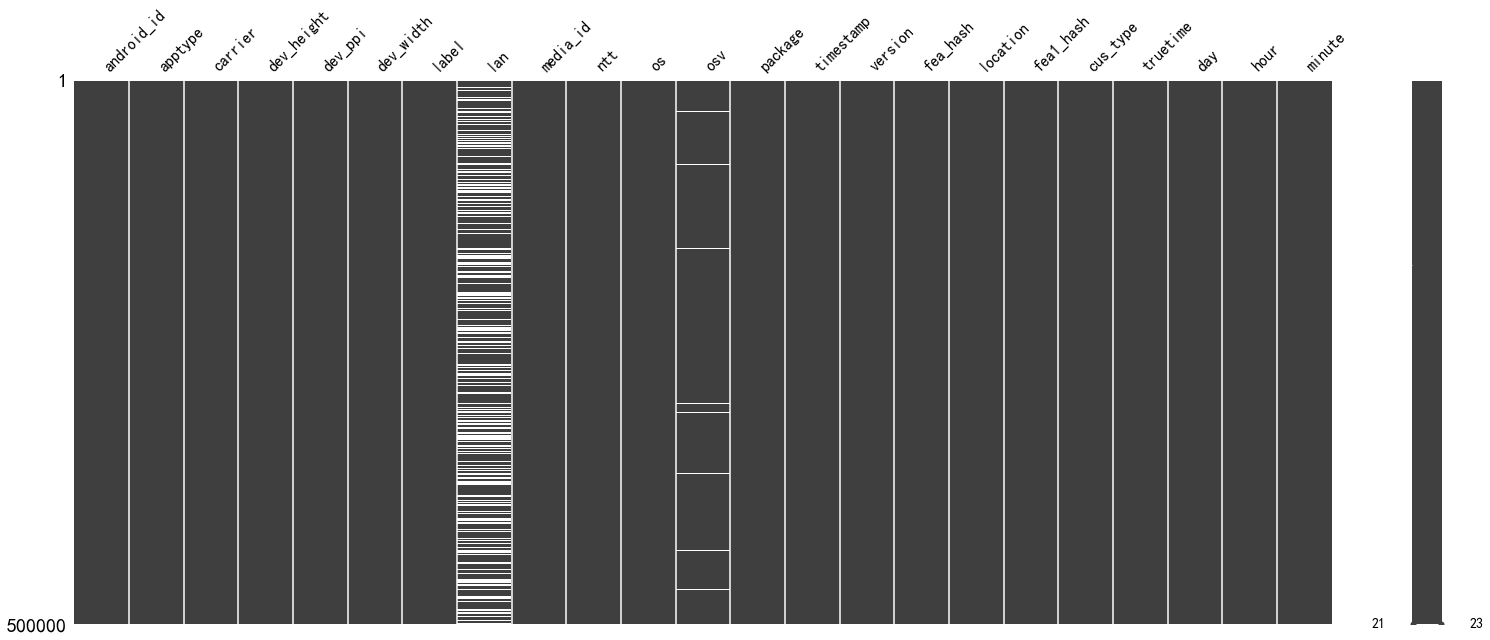

In [5]:
msno.matrix(df_train);

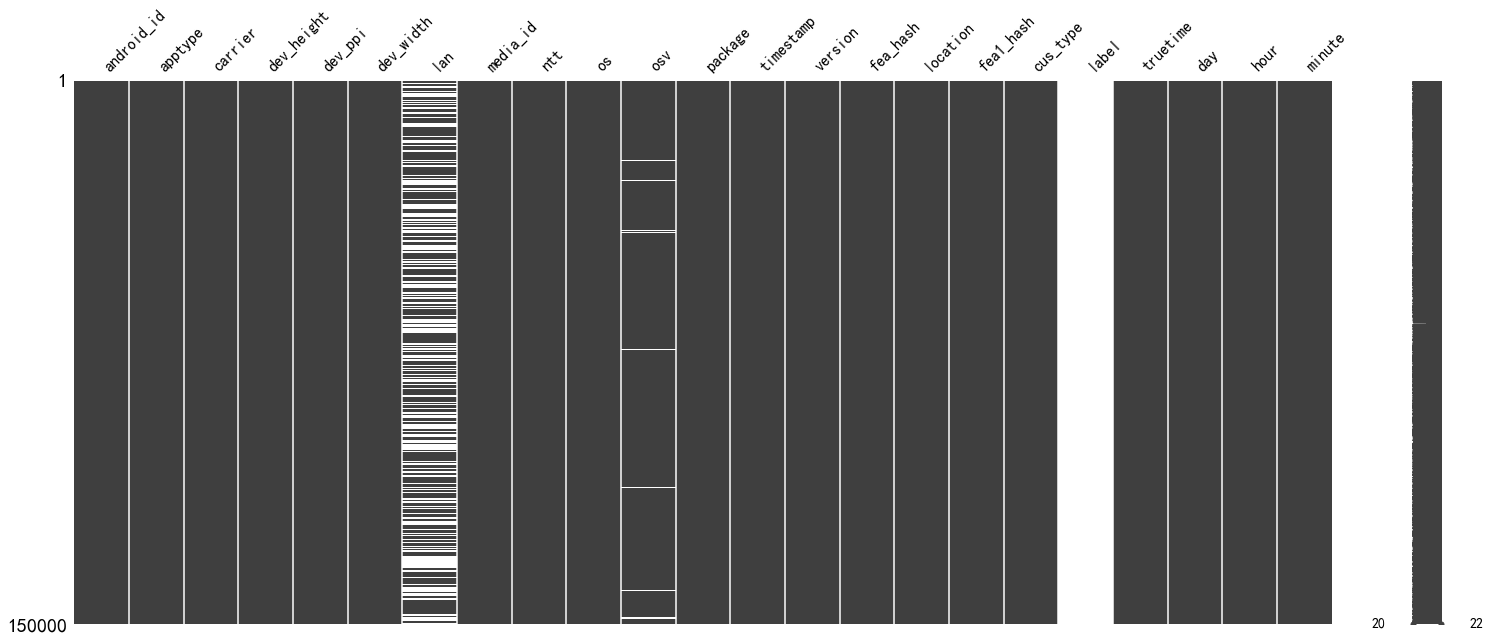

In [6]:
msno.matrix(df_test);

In [54]:
# df_train.to_pickle("../processed_data/final_read_train.pkl")
# df_test.to_pickle("../processed_data/final_read_test.pkl")

## EDA实验

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import datetime
import seaborn as sns
import gc
import re
# from pandarallel import pandarallel
# pandarallel.initialize()
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
#显示所有列
pd.set_option('display.max_columns', 100)
#显示所有行
pd.set_option('display.max_rows', 100)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',70)

In [8]:
df_train=pd.read_pickle("../processed_data/final_process_train.pkl")
df_test=pd.read_pickle("../processed_data/final_process_test.pkl")

In [9]:
df_train["type"]="train"
df_test["type"]="test"
df_all=df_train.append(df_test)

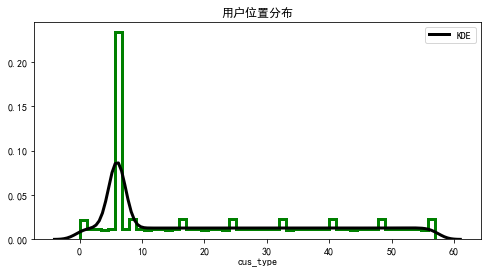

In [10]:
plt.figure(figsize=(8,4))
plt.title('用户位置分布')
sns.distplot(df_train.cus_type,kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})
plt.show()

In [11]:
df_all.lan.value_counts()

7.0    563401
6.0     53914
1.0     32307
4.0       150
2.0       115
5.0        59
8.0        37
3.0        17
Name: lan, dtype: int64

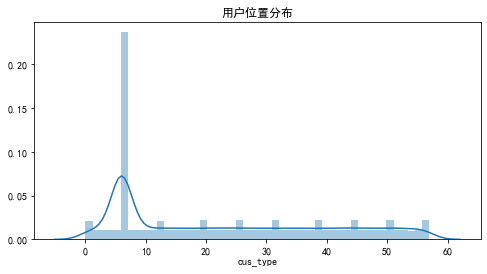

In [12]:
plt.figure(figsize=(8,4))
plt.title('用户位置分布')
sns.distplot(df_test.cus_type)
plt.show()

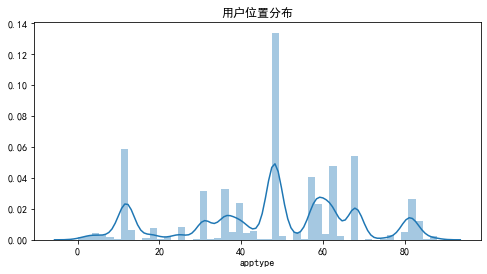

In [16]:
plt.figure(figsize=(8,4))
plt.title('用户位置分布')
sns.distplot(df_test.apptype)
plt.show()

In [52]:
df_all.dev_width.value_counts().head(90)

1080.0    273016
360.0     100300
720.0      82136
972.0      21287
912.0      16918
1112.0      9941
1129.0      9552
802.0       9525
975.0       9253
1233.0      8875
393.0       8239
900.0       6396
1440.0      5761
1520.0      5560
1152.0      5107
320.0       5065
480.0       5016
800.0       4891
1920.0      4852
540.0       4374
1067.0      4045
864.0       4033
640.0       3749
1024.0      2856
1035.0      2732
1280.0      1987
1053.0      1970
2280.0      1827
1088.0      1816
1380.0      1753
2340.0      1747
1078.0      1590
810.0       1516
945.0       1335
1204.0      1214
2160.0      1199
412.0        935
2196.0       867
2034.0       822
2159.0       711
2130.0       619
2136.0       584
2128.0       572
1208.0       526
1271.0       482
1424.0       460
2016.0       447
768.0        446
2190.0       443
1200.0       429
2137.0       416
359.0        389
1050.0       377
1800.0       353
960.0        343
1128.0       340
1185.0       334
2060.0       305
432.0        2

In [53]:
a=df_all.dev_height.unique()
a=sorted(a)
b=df_all.dev_height.value_counts().index
b=list(b)
for num in a:
    print(num,b.index(num))

7.0 508
8.0 484
9.0 461
10.0 475
11.0 336
12.0 358
13.0 388
14.0 431
15.0 400
16.0 356
17.0 396
18.0 374
19.0 432
20.0 408
21.0 373
22.0 436
23.0 477
100.0 262
140.0 753
174.0 745
200.0 627
233.0 791
240.0 366
280.0 612
282.0 742
284.0 524
286.0 746
300.0 756
320.0 218
340.0 738
344.0 751
360.0 224
369.0 744
379.0 762
382.0 705
392.0 624
400.0 491
408.0 571
420.0 533
426.0 397
432.0 545
440.0 375
441.0 785
444.0 741
446.0 779
448.0 723
450.0 488
452.0 595
456.0 683
458.0 740
466.0 692
468.0 690
471.0 687
472.0 644
480.0 27
483.0 676
484.0 680
485.0 497
494.0 418
497.0 630
498.0 718
500.0 321
503.0 713
505.0 529
506.0 649
512.0 332
513.0 633
517.0 372
518.0 478
519.0 686
522.0 523
524.0 411
525.0 291
526.0 454
527.0 584
529.0 754
530.0 283
531.0 739
532.0 626
534.0 482
536.0 770
540.0 125
550.0 733
552.0 526
554.0 620
558.0 693
559.0 564
560.0 643
562.0 679
564.0 472
565.0 246
566.0 231
567.0 360
568.0 342
569.0 191
570.0 166
572.0 84
577.0 481
582.0 775
589.0 672
592.0 247
596.0 563
59

In [56]:
df_all.sort_values(["location","dev_width","timestamp"])[["android_id","location","apptype","carrier","dev_height","dev_ppi","dev_width","lan","media_id","fea_hash","fea1_hash","version","osv","label","day","hour","minute","type"]].head(99)

,android_id,location,apptype,carrier,dev_height,dev_ppi,dev_width,lan,media_id,fea_hash,fea1_hash,version,osv,label,day,hour,minute,type
sid,,,,,,,,,,,,,,,,,,
1932516,0,0,48,1,694.0,1.0,320.0,7.0,6,0,1765,7.0,116,None,3,1,42,test
1953285,0,0,48,1,665.0,1.0,320.0,7.0,6,0,1692,7.0,116,1,3,1,47,train
1977137,0,0,48,1,664.0,1.0,320.0,7.0,6,0,1724,7.0,65,1,3,8,51,train
1917535,651677,0,8,1,480.0,1.0,320.0,6.0,138,0,0,2.0,64,0,3,9,20,train
1951270,0,0,48,1,665.0,1.0,320.0,7.0,6,0,1724,7.0,116,1,3,12,32,train
1824341,0,0,48,1,676.0,1.0,320.0,7.0,6,19867,1708,7.0,109,1,3,17,22,train
1841509,0,0,48,1,676.0,1.0,320.0,7.0,6,29360,1653,7.0,109,1,4,6,52,train
1811368,0,0,48,1,694.0,1.0,320.0,7.0,6,0,1671,7.0,116,1,4,9,29,train
1731391,0,0,49,1,320.0,480.0,320.0,2.0,28,18750,555,9.0,64,None,4,19,55,test
